# Imports


In [193]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Access functions

In [194]:
def retrieve_time(path):
    """
    This function retrieves the timing of a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output:
     - A float representing time or an error
    """
    f = open(path + "/job.out", "r")
    return float(f.readlines()[1][6:])

In [195]:
def retrieve_settings(path):
    """
    This function retrieves all the settings for a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output: 
     - A numpy array of settings in format np.float64
    """
    options = path.split("/")
    settings = np.array([], dtype=np.float64)
    for set in options:
        if not str.isalpha(set.split("_")[-1]):
            settings = np.append(settings, np.float64(set.split("_")[-1]))
            
    return settings

# Dataset creation

In [196]:
# These indexes allow us to rapidly swap the number of parameter in consideration during generation.

sequential_idx = {"seq_length": 0, "patterns": 1, "mean_path_length": 2, "time_std": 3, "mean_time": 4}
pthreads_idx = {"threads": 0, "seq_length": 1, "patterns": 2, "mean_path_length": 3, "time_std": 4, "mean_time": 5}

In [197]:
def raw_dataset(path, dataset):
    """
    This function recursively explores the results folder and gathers data about the measurements.

    Input:
     - path: the path of the dataset
     - dataset: whatever numpy array of np.float64 with the same dimension as the measurement variables

     Output: 
      - The dataset as a numpy array of np.float64. The shape of the array is (measurements, variables),
        where the last variable is the timing of the measurement
    """
    new_dataset = np.copy(dataset)
    if not os.path.isdir(path) or os.listdir(path) == []:
        return dataset
    elif "job.out" in os.listdir(path):
        try:
            time = retrieve_time(path)
            settings = retrieve_settings(path)
            row = np.append(settings, np.float64(time)).reshape(1, -1)
            return np.append(new_dataset, row, axis=0)
        except:
            return new_dataset
    else:
        for dir in os.listdir(path):
            new_dataset = raw_dataset(path + "/" + dir, new_dataset)

    return new_dataset

In [198]:
# Testing

sequential_times = raw_dataset("results/logs/sequential", np.zeros(shape=(1, len(sequential_idx)), dtype=np.float64))
np.set_printoptions(threshold=np.inf)
sequential_times[np.lexsort(np.transpose(sequential_times)[::-1])]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 1.00000000e+00,
        6.56900000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 2.00000000e+00,
        6.32300000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 3.00000000e+00,
        7.07300000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 4.00000000e+00,
        6.37100000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 5.00000000e+00,
        9.47800000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 6.00000000e+00,
        1.03720000e-02],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 7.00000000e+00,
        9.58200000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 8.00000000e+00,
        8.31300000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 9.00000000e+00,
        6.52200000e-03],
       [1.00000000e+01, 1.0000

## Aggregating on data to get mean and std

In [199]:
def aggregate_dataset(dataset):
    """
    This function takes in input a dataset of type (feature1, feature2... test_n, time), and returns a dataset of type (feature1, feature2... time_std, mean_time), with std and mean taken by aggregating on (feature1...feature(n-2)).

    Input:
     - dataset: a numpy array of np.float64 as in the description

    Output:
     - a numpy array of np.float64 as in the description
    """
    # Creating the dataset of settings
    dataset_unique = np.unique(dataset[:, :-2], axis=0)

    # Creating the dataset with mean and std
    aggregated = np.zeros((1, dataset.shape[1]), np.float64)
    for el in dataset_unique:
        # Creating the temporary array with a single setting
        tmp = np.zeros((1, dataset.shape[1]), np.float64)
        count = 0

        # Adding the real datapoints to such array
        for i in range(dataset.shape[0]):
            if np.array_equal(dataset[i, :-2], el):
                datapoint = np.reshape(dataset[i,], (1, -1))
                tmp = np.append(tmp, datapoint, axis=0)
                count += 1

        # Calculating mean and std by first removing the fake datapoint
        tmp = tmp[1:]
        tmp[:, -2] = np.std(tmp[:, -1])/np.sqrt(count)
        tmp[:, -1] = np.mean(tmp[:, -1])

        # Appending to the final dataset
        aggregated = np.append(aggregated, np.reshape(tmp[0], (1, -1)), axis=0)

    return aggregated[1:, ]

## Clean dataset creation


In [200]:
def create_dataset(path, idx, first_setting_column = 0):
    dataset = raw_dataset(path, np.zeros(shape=(1, len(idx)), dtype=np.float64))[1:, :]
    dataset[:, first_setting_column:-2] = np.power(2, dataset[:, first_setting_column:-2])
    dataset = dataset[np.lexsort(np.transpose(dataset)[::-1])]
    dataset = aggregate_dataset(dataset)
    return dataset

In [201]:
# Testing

sequential = create_dataset("results/logs/sequential", sequential_idx)
pthreads = create_dataset("results/logs/pthreads", pthreads_idx, first_setting_column=1)
pthreads

array([[2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
        1.20486850e-04, 3.63930000e-03],
       [2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 6.40000000e+01,
        1.74217003e-04, 4.79560000e-03],
       [2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 2.56000000e+02,
        7.39414971e-05, 3.60150000e-03],
       [2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.02400000e+03,
        1.22990199e-04, 1.13390000e-03],
       [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
        3.48834438e-03, 1.09050900e-01],
       [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 6.40000000e+01,
        1.35173029e-03, 1.26821600e-01],
       [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 2.56000000e+02,
        3.72048031e-03, 1.15230300e-01],
       [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.02400000e+03,
        1.11319575e-03, 1.92918000e-02],
       [2.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
        5.87142545e-02, 

## Possible values of each variable

In [202]:
def domain(dataset, variable):
    """
    This function retrieves all the possible values of the dataset EXCLUDING the given variable, time_std and mean_time. 
    
    For example, if the variable is seq_length and the dataset is
    
    [seq_length | patterns | mean_path_length | time_std | mean_time] //this line is not actually part of the array
    
    [[10          10         4                   0.012    0.5]\n
    [15          10         4                   0.030     0.02]\n
    [20          15         4                   0.70      0.9]]\n

    the output will be

    [patterns | mean_path_length] //this line is not actually part of the array
    
    [[10        4]\n
    [15         4]]\n

    Input:
     - dataset: the output of create_dataset
     - variable: a value of an index dictionary (e.g. sequential_idx), whose column will
       be excluded when creating the set of unique values. Make sure the column actually matches
       the content of the given dataset

    Output:
     - a numpy array containing the described result 
    """
    return np.unique(np.delete(dataset, variable, axis=1)[:, :-2], axis=0)

In [203]:
# Testing

domain(sequential, sequential_idx["patterns"])

array([[1.024000e+03, 1.600000e+01],
       [1.024000e+03, 6.400000e+01],
       [1.024000e+03, 2.560000e+02],
       [1.024000e+03, 1.024000e+03],
       [3.276800e+04, 1.600000e+01],
       [3.276800e+04, 6.400000e+01],
       [3.276800e+04, 2.560000e+02],
       [3.276800e+04, 1.024000e+03],
       [3.276800e+04, 4.096000e+03],
       [1.048576e+06, 1.600000e+01],
       [1.048576e+06, 6.400000e+01],
       [1.048576e+06, 2.560000e+02],
       [1.048576e+06, 1.024000e+03],
       [1.048576e+06, 4.096000e+03],
       [1.048576e+06, 1.048576e+06]])

# Comparing datasets


In [204]:
def comparison(dataset1, method1_idx, dataset2, method2_idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - dataset1: an output of create_dataset
     - method1_idx: the dictionary of variables and indices associated to the first dataset
     - dataset2: an output of create_dataset
     - method2_idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - Two arrays with shape (configurations, range(variable)*measurements_per_configuration, len(methodj_idx) + 1),
       one per datset, where:
        - configurations is the output length of domain(datasetj, variable)
        - range(variable) is the number of total settings for that specific variable
        - measurements_per_configuration is the number of measurements per each experiment setting (including the variable itself)
        - len(methodj_idx) is the number of variables of a certain datset
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset1 = []
    new_dataset2 = []
    for const in domain(dataset1, method1_idx[variable]):
        values = np.copy(dataset1)
        for i in range(dataset1.shape[1] - 3):
            if i >= method1_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset1.append(values)

    for const in domain(dataset2, method2_idx[variable]):
        values = np.copy(dataset2)
        for i in range(1, dataset2.shape[1] - 3):
            if i >= method2_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset2.append(values)
            
    return new_dataset1, new_dataset2

In [205]:
def sequential_vs_pthreads(variable):
    """
    A wrapper of the comparison function for sequential and pthreads data.
    """
    return comparison(sequential, sequential_idx, pthreads, pthreads_idx, variable)

In [206]:
# Testing

sequential_vs_pthreads("patterns")

([array([[1.02400000e+03, 1.02400000e+03, 1.60000000e+01, 4.79300199e-04,
          7.68770000e-03],
         [1.02400000e+03, 3.27680000e+04, 1.60000000e+01, 9.27881410e-03,
          2.20542000e-01],
         [1.02400000e+03, 1.04857600e+06, 1.60000000e+01, 3.80685691e-01,
          8.02322770e+00],
         [1.02400000e+03, 3.35544320e+07, 1.60000000e+01, 2.23980775e+00,
          2.10416964e+02]]),
  array([[1.02400000e+03, 1.02400000e+03, 6.40000000e+01, 6.38422603e-04,
          9.40300000e-03],
         [1.02400000e+03, 3.27680000e+04, 6.40000000e+01, 8.88869690e-03,
          2.69540200e-01],
         [1.02400000e+03, 1.04857600e+06, 6.40000000e+01, 1.20678915e-01,
          8.54878290e+00],
         [1.02400000e+03, 3.35544320e+07, 6.40000000e+01, 1.88782161e+00,
          2.64245458e+02]]),
  array([[1.02400000e+03, 1.02400000e+03, 2.56000000e+02, 6.85283183e-04,
          8.93070000e-03],
         [1.02400000e+03, 3.27680000e+04, 2.56000000e+02, 1.96197211e-03,
          2.2

# Comparison plotting

## Sequential vs PThreads

In [207]:
def plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    x_sequential, x_pthreads = sequential_vs_pthreads(variable)

    # Setting up the plots
    fig, axis = plt.subplots(len(x_sequential))

    # Fixing the interesting indexes
    seq_idx = sequential_idx[variable]
    pth_idx = pthreads_idx[variable]

    # Plotting each and every grouping
    for i, data in enumerate(zip(x_sequential, x_pthreads)):
        seq = data[0]
        pth = data[1]

        # Checking that groupings actually contain the same measurements
        if not np.array_equal(seq[0, :-2], pth[0, 1:-2]):
            print("Error! Groupings do not contain the same configurations")
            return
        
        # Checking that groupings have at least two measurements
        if (seq.shape[0] < 2 or pth.shape[0] < 2):
            print(f"Configuration {np.array2string(seq[0, :-2])} has been skipped due to lack of data")
            print(f"Sequential data has {seq.shape[0]} datapoints")
            print(f"PThreads data has {pth.shape[0]} datapoints")
            fig.delaxes(axis[i])
            continue

        # Ordering groupings by the interesting variable
        seq = seq[np.argsort(seq[:,seq_idx])]
        pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        axis[i].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
        
        # Plotting a 95% ci 
        span = 1.96 * seq[:, -2]
        lower_ci = seq[:, -1] - span
        upper_ci = seq[:, -1] + span
        axis[i].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
        
        # Plotting the expected parallel speedup for the chosen grouping
        for num_cores, colour in zip((sorted(set(pth[:, 0]))), ("red", "blue", "orange", "green")):
            exp_label = "Expected speedup for " + str(int(num_cores)) + " threads"
            def speedup(time):
                return time/num_cores
            exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

            axis[i].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "orange", "green")):
            pth_group = pth[pth[:, 0] == j]
            pth_label = str(int(pth_group[0, 0])) + " threads"

            axis[i].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
        
            # Plotting a 95% ci 
            span = 1.96 * pth_group[:, -2]
            lower_ci = pth_group[:, -1] - span
            upper_ci = pth_group[:, -1] + span

            axis[i].fill_between(pth_group[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)

            # Debugging std
            print(np.max(span))

        # Finishing the plot
        title = ""
        for k in sequential_idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(seq[0, sequential_idx[k]]) + "\n"
        axis[i].set_title(title)
        axis[i].set_xlabel(variable)
        axis[i].set_ylabel('Time (s)')
        axis[i].set_yscale('log')
        axis[i].set_xscale('log', base = 2)
        axis[i].legend()
        axis[i].grid()
        
    fig.set_figheight(len(axis)*6)
    plt.legend()
    plt.tight_layout()
    plt.show()

28.628529436395258
41.65349147725621
178.16680907457888
137.10226664120873
642.5394726089478
275.09983050553205
291.96249987708245
322.8361119090119
24.881871116900104
163.9549435507243
223.3791395338481
1.1100819308559717
0.39054691981249934
0.22072642583289018
0.3085878140489277
0.5723044452097604
11.74526446827915
20.017488917164748
310.24311312600935
99.32795813219467
46.51708317469498
92.60989691313728
55.27550103128397
64.4953614099711
12.726964424376431
33.31752864118703
219.06424402122096
77.51992886894236
49.822954823670806
86.00054414300634
123.5596857958865
322.4125179843291
456.87044809964914
439.73335537030783
316.2766727872977
221.36051651238387
14.004908864799685
337.5419047091857
231.5438225404786
92.38753214013181
130.93173610798146
28.811436168761926
27.188022658553873
103.73753082677108
84.47452357924895
28.844587414275185
43.67118169952706
30.003633358731303
43.959501992941284
28.02781637224285
115.33288544023277
110.27189936956869
30.817983969947818
28.134977548227

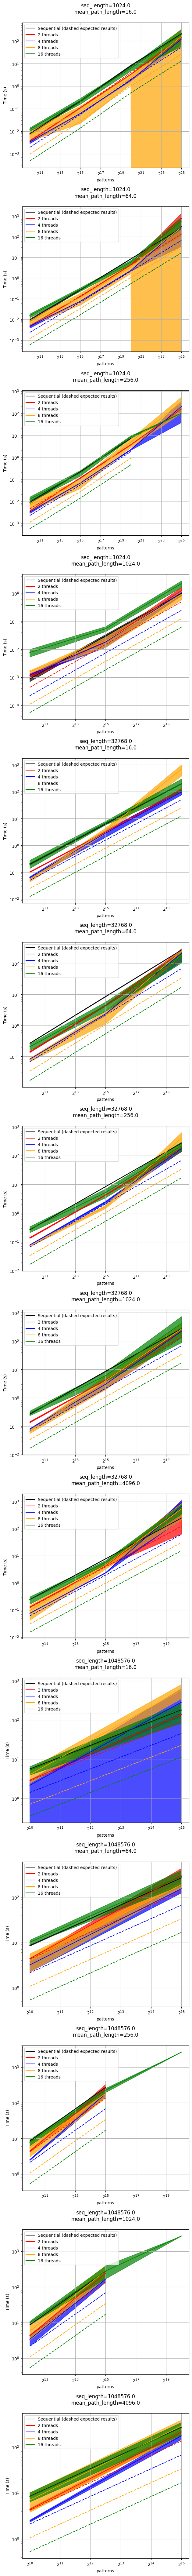

In [208]:
plot_variable_sequential_pthreads("patterns")